In [193]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchviz import make_dot
from tqdm import tqdm, tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
torch.manual_seed(99)


In [283]:
### Config
class CFG:
    seed = 99
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 32
    model_path = ".\model"

class CFG_XOR:
    XOR_data_path = ".\Xor_Dataset.csv"
    batch_size = 128
    input_size = 2
    output_size = 1
    input = ['X', 'Y']
    output = 'Z'
    epochs = 100
    lr = 0.01

class CFG_MNIST:
    MNIST_data_path = ".\MNIST_data"
    batch_size = 256
    input_size = 28*28
    output_size = 10
    input = ['pixel_{}'.format(i) for i in range(784)]
    output = ['class_{}'.format(i) for i in range(10)]
    epochs = 10
    lr_list = [0.01, 0.001, 0.0001]

# BAI 1: XOR

In [195]:
XOR_df = pd.read_csv(CFG_XOR.XOR_data_path)# Kaggle XOR dataset
XOR_df.head(10)

,X,Y,Z
0,0,0,0
1,0,1,1
2,1,1,0
3,1,1,0
4,0,0,0
5,1,0,1
6,1,1,0
7,1,1,0
8,0,1,1
9,1,0,1


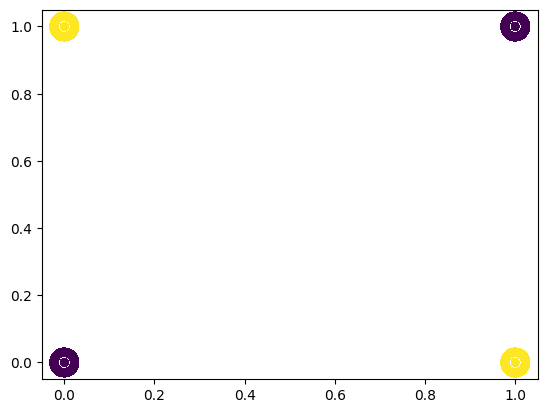

In [196]:
plt.scatter(XOR_df['X'], XOR_df['Y'], c=XOR_df['Z'], linewidths=15)

In [197]:
class XORDataModule():
    def __init__(self):
        self.data = pd.read_csv(CFG_XOR.XOR_data_path)
        self.batch_size = CFG_XOR.batch_size

    def train_test_split(self):
        X = self.data[['X', 'Y']].to_numpy()
        y = self.data['Z'].to_numpy().reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True)
        return X_train, X_test, y_train, y_test

    def data_loader(self, train=True):
        if train:
            X_train, _, y_train, _ = self.train_test_split()
            return DataLoader(
                list(zip(torch.tensor(X_train), torch.tensor(y_train))),
                batch_size=self.batch_size, shuffle=True)
        else:
            _, X_test, _, y_test = self.train_test_split()
            return DataLoader(
                list(zip(torch.tensor(X_test), torch.tensor(y_test))),
                batch_size=self.batch_size, shuffle=False)


In [198]:
class XORNN(nn.Module):
    def __init__(self):
        super(XORNN, self).__init__()
        self.layer1 = nn.Linear(CFG_XOR.input_size, 3)
        self.layer2 = nn.Linear(3, CFG_XOR.output_size)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        return x


In [199]:
xor_datamodule = XORDataModule()
xor_model = XORNN().to(CFG.device)

In [200]:
xor_train = xor_datamodule.data_loader()
xor_test = xor_datamodule.data_loader(train=False)
criterion = nn.MSELoss()
optimizer = optim.SGD(xor_model.parameters(), lr=CFG_XOR.lr)
epoch_loss_hist = []
batch_loss_hist = []

In [201]:
for epoch in range(CFG_XOR.epochs):
    for X, y in xor_train:
        optimizer.zero_grad()
        y_hat = xor_model(X.float())
        loss = criterion(y_hat, y.float())
        batch_loss_hist.append(loss.detach())
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{CFG_XOR.epochs}], Loss: {loss.item():.4f}')
    epoch_loss_hist.append(loss.detach())

Epoch [1/100], Loss: 0.2878


Epoch [11/100], Loss: 0.2542
Epoch [21/100], Loss: 0.1964
Epoch [31/100], Loss: 0.0972
Epoch [41/100], Loss: 0.0224
Epoch [51/100], Loss: 0.0028
Epoch [61/100], Loss: 0.0002
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000


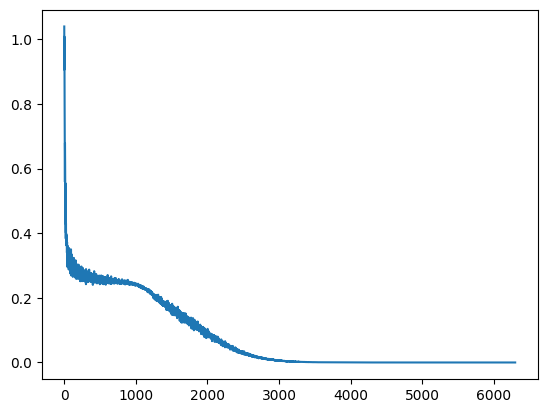

In [202]:
plt.plot(batch_loss_hist)

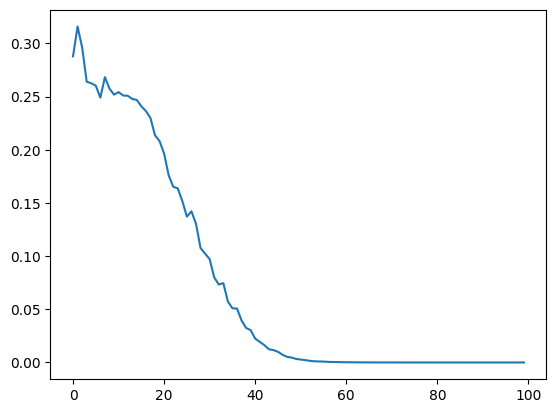

In [203]:
plt.plot(epoch_loss_hist)

# BAI 2

In [204]:
class MNISTDataModule():
    def __init__(self):
        self.batch_size = CFG.batch_size
        self.train = None
        self.val = None

    def data_loader(self):
        self.train = DataLoader(
            torchvision.datasets.MNIST(
                CFG_MNIST.MNIST_data_path,
                train=True, download=True,
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        (0.1307,), (0.3081,))])),
                batch_size=self.batch_size, shuffle=True)
        
        self.val = DataLoader(
            torchvision.datasets.MNIST(
                CFG_MNIST.MNIST_data_path,
                train=False, download=True,
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        (0.1307,), (0.3081,))])),
                batch_size=self.batch_size, shuffle=False)


In [205]:
class MNISTNN(nn.Module):
    def __init__(self):
        super(MNISTNN, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 20)
        self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [206]:
mnist_datamodule = MNISTDataModule()
mnist_datamodule.data_loader()

In [207]:
(len(mnist_datamodule.val.dataset) /
(len(mnist_datamodule.train.dataset) + len(mnist_datamodule.val.dataset))) * 100
# close to 20%

14.285714285714285

Label: tensor(5)


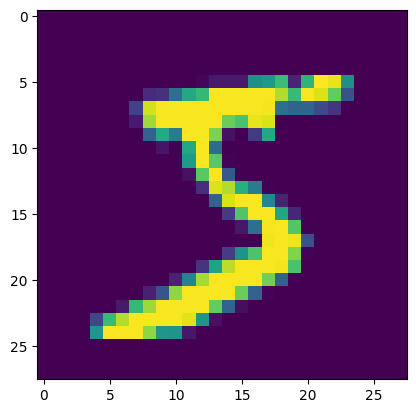

In [208]:
plt.imshow(mnist_datamodule.train.dataset[0][0].view(28, 28))
print("Label:", mnist_datamodule.train.dataset.targets[0])

In [280]:
def init(lr):
    mnist_model = MNISTNN()
    mnist_model.to(CFG.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mnist_model.parameters(), lr=lr)
    epoch_loss_hist = []
    batch_loss_hist = []
    return mnist_model, criterion, optimizer, epoch_loss_hist, batch_loss_hist


def evaluate_model(model):
    model.eval()
    mse = 0
    mae = 0
    mape = 0
    with torch.no_grad():
        for X, y in mnist_datamodule.val:
            y_hat = model(X.view(-1, 28*28))
            y_hat = y_hat.argmax(dim=1).float()
            y = y.float()
            mse += torch.mean((y_hat - y)**2)
            mae += torch.mean(torch.abs(y_hat - y))
            mape += torch.mean(torch.abs((y_hat - y) / y))

    mse /= len(mnist_datamodule.val.dataset)
    mae /= len(mnist_datamodule.val.dataset)
    mape /= len(mnist_datamodule.val.dataset)
    print('MSE: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(mse, mae, mape))


def viz_batch_loss():
    plt.plot(batch_loss_hist)
    plt.title('Batch Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()


def viz_epoch_loss():
    plt.plot(epoch_loss_hist)
    plt.title('Epoch Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


Epoch [1/10], Loss: 0.0589
MSE: 0.0498, MAE: 0.0104, MAPE: nan


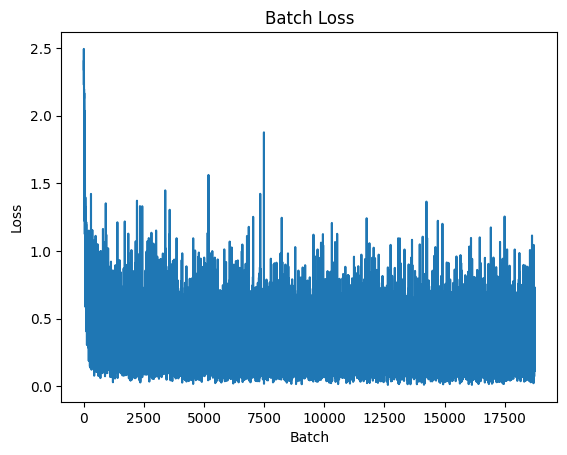

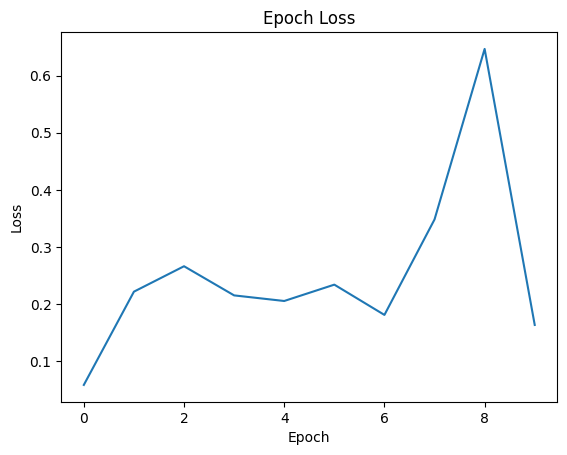

Epoch [1/10], Loss: 0.0849
MSE: 0.0243, MAE: 0.0050, MAPE: nan


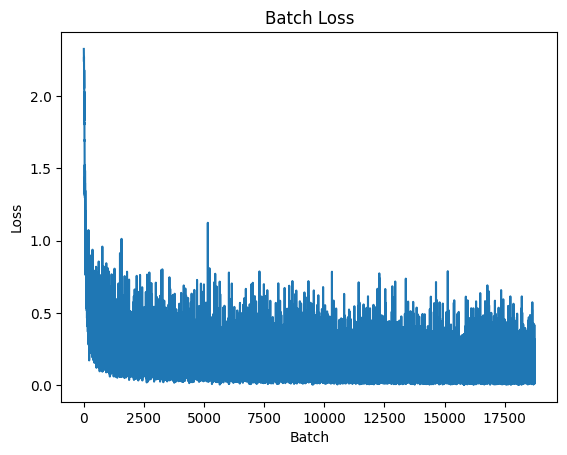

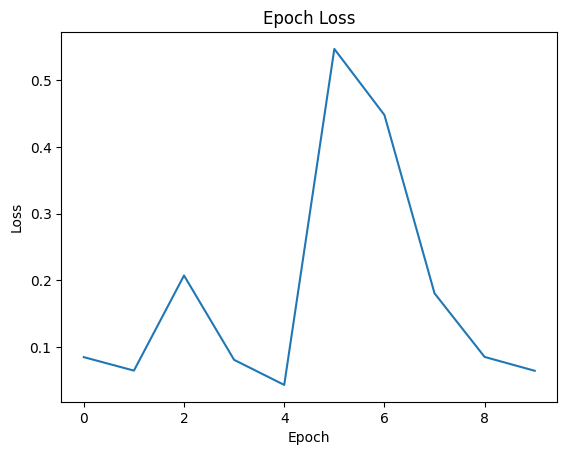

Epoch [1/10], Loss: 0.5521
MSE: 0.0334, MAE: 0.0070, MAPE: nan


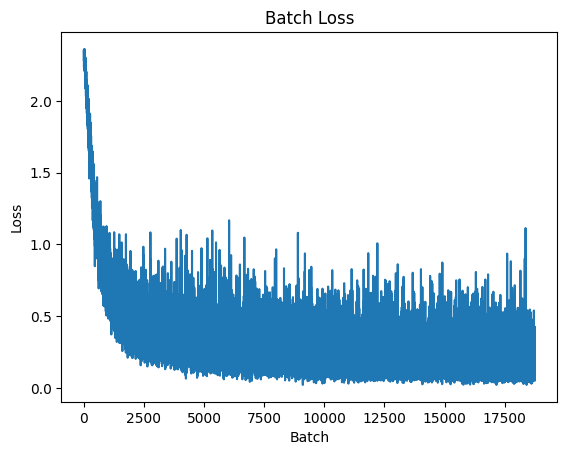

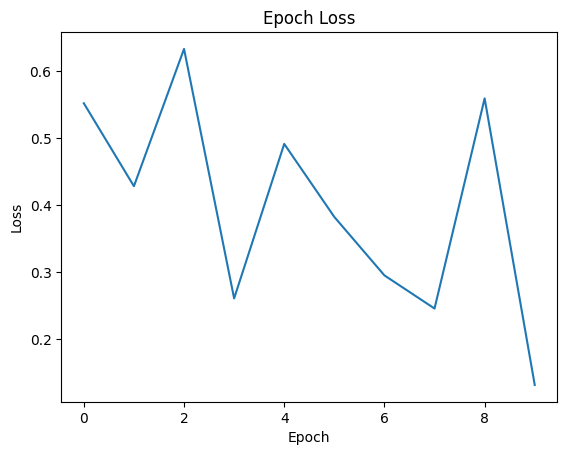

In [284]:
for lr in CFG_MNIST.lr_list:
    mnist_model, criterion, optimizer, epoch_loss_hist, batch_loss_hist = init(lr)
    for epoch in range(CFG_MNIST.epochs):
        for X, y in mnist_datamodule.train:
            optimizer.zero_grad()
            y_hat = mnist_model(X.view(-1, 28*28))
            loss = criterion(y_hat, y)
            batch_loss_hist.append(loss.detach())
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{CFG_MNIST.epochs}], Loss: {loss.detach():.4f}')
        epoch_loss_hist.append(loss.detach())
    evaluate_model(mnist_model)
    viz_batch_loss()
    viz_epoch_loss()


# BAI 3

Hàm softmax được sử dụng để tạo ra một phân phối xác suất trên các lớp đầu ra của mạng nơ-ron. Để phân phối này hợp lệ, nó phải thỏa mãn hai điều kiện:

1. Tổng của tất cả các xác suất phải bằng 1.
2. Không có xác suất nào có thể lớn hơn 1.
Hàm exponential function (e) thỏa mãn cả hai điều kiện này. Nó là một hàm liên tục và tăng dần, vì vậy tổng của tất cả các giá trị của nó sẽ luôn bằng 1. Ngoài ra, giá trị lớn nhất của hàm exponential function là e, vì vậy không có giá trị nào của hàm có thể lớn hơn 1.

Sử dụng các số khác như 2, 3 hoặc 4 sẽ không thỏa mãn điều kiện thứ hai. Ví dụ, nếu chúng ta sử dụng hàm mũ 2, thì giá trị lớn nhất của hàm có thể bằng 2. Điều này có nghĩa là các xác suất của các lớp đầu ra có thể lớn hơn 1, dẫn đến phân phối xác suất không hợp lệ.